# College Scorecard Exploration

Here, I will be looking at various attributes contained within the Department of Education's College Scorecard dataset. A breakdown of completion rates, admission rates, and school selectivity. I will be doing a "deep dive" on completion rates to try and uncover why some schools produce more graduates than others. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [4]:
df = pd.read_csv('Most-Recent-Cohorts-All-Data-Elements.csv', low_memory=False)

First, how many samples and variables are there?

In [5]:
print("Unique intstitutions - ", len(pd.unique(df['UNITID'])))
print("Number of variables - ", len(df.columns))

Unique intstitutions -  6694
Number of variables -  2392


## State Level

How many schools are there per state?

In [9]:
state_count = Counter(df['STABBR'])
{k: v for k, v in sorted(state_count.items(), key=lambda item: item[1], reverse = True)}

{'CA': 693,
 'NY': 455,
 'TX': 433,
 'FL': 378,
 'PA': 353,
 'OH': 289,
 'IL': 258,
 'MI': 192,
 'NC': 179,
 'GA': 175,
 'NJ': 168,
 'VA': 168,
 'MO': 158,
 'MA': 156,
 'TN': 155,
 'PR': 144,
 'IN': 139,
 'LA': 121,
 'AZ': 114,
 'MN': 112,
 'OK': 108,
 'WA': 105,
 'CO': 101,
 'SC': 100,
 'WI': 95,
 'AR': 92,
 'KY': 90,
 'AL': 89,
 'MD': 85,
 'IA': 80,
 'KS': 80,
 'CT': 79,
 'OR': 78,
 'WV': 73,
 'UT': 71,
 'MS': 59,
 'NM': 49,
 'NE': 42,
 'ID': 38,
 'ME': 38,
 'NV': 38,
 'NH': 37,
 'MT': 32,
 'SD': 28,
 'ND': 26,
 'DC': 25,
 'RI': 23,
 'VT': 22,
 'DE': 21,
 'HI': 21,
 'WY': 10,
 'AK': 9,
 'GU': 3,
 'VI': 2,
 'AS': 1,
 'MP': 1,
 'FM': 1,
 'PW': 1,
 'MH': 1}

<AxesSubplot:ylabel='Density'>

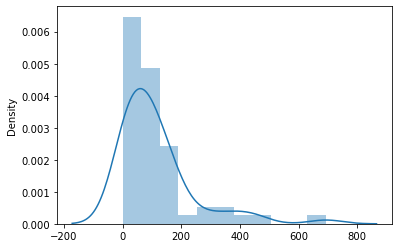

In [19]:
plot = []
for each in state_count.items():
    plot.append((each[1]))
sns.distplot(plot)

It appears that the number of institutions rises with state population. 

## Completion Rate

#### Note on Variables:
>Because I want to eventually break everyhting down by race, for sake of consistency I will use completion within 150% of expected time for my variable. This is becasue race is only reported for the 150% of expected time variable in this
data. The schools are represented by the variables C150_4 (4-year schools) and C150_L4 (less-than-4 year schools). It makes sense to combine the completion rates of C150_4 and C150_L4 since no samples fall into both categories. Also, I have decided against the use of the pooled versions of the 150% expected graduation time data again for sake of consistency with the racial data. The racial data is only reported year to year and is not based on averages like the pooled completion rates. 

count    5499.000000
mean        0.553665
std         0.236376
min         0.000000
25%         0.363800
50%         0.568100
75%         0.735800
max         1.000000
Name: completion_rate, dtype: float64

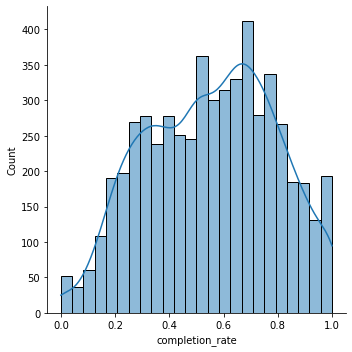

In [6]:
s1 = pd.Series(df['C150_4'])
s2 = pd.Series(df['C150_L4'])
completion_rate = s1.combine_first(s2)
completion_rate = completion_rate.rename("completion_rate")
sns.displot(completion_rate, kde=True)
completion_rate.describe()

Looking pretty good here. The data is not heavilly skewed, but it looks like most folks are graduating within 150% of the normal time with a mean completion rate of about 55%. 

## Admission Rate

#### Note on Variables:
>Schools report their admission rates as a decimal through the variable ADM_RATE_ALL. However, some schools admit all students that apply or meet minimum requirements (recorded in the variable OPENADMP), and NaN often fills this admission rate attribute for those schools. If the admission rate for a school is NaN and the sample is an open enrollment school, it can be assumed the admission rate for that school is 100%. The COSTT4_A and COSTT4_P variables contain average cost of attendance data for the school. The combination of the COSTT4_A and COSTT4_P variables gives an average cost of attendance for each school. 

count    5903.000000
mean        0.882607
std         0.200544
min         0.000000
25%         0.807200
50%         1.000000
75%         1.000000
max         1.000000
Name: ADM_RATE_WITH_OPEN, dtype: float64 

count    2242.000000
mean        0.690913
std         0.215971
min         0.000000
25%         0.573550
50%         0.732900
75%         0.848175
max         1.000000
Name: ADM_RATE_NONOPEN, dtype: float64


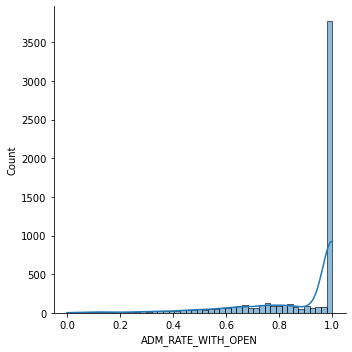

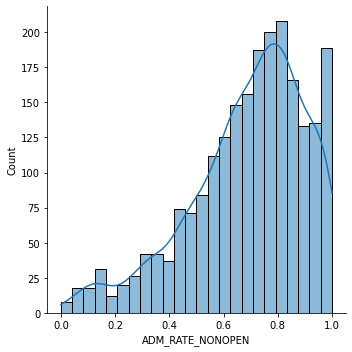

In [7]:
#Creation of dataframe for the rest of analysis
rate_df = df[['UNITID','OPENADMP','ADM_RATE_ALL', 'CONTROL','COSTT4_A','COSTT4_P']]
rate_df = rate_df.replace({'CONTROL':{1: "Public", 2: "Private", 3:"Private"}})
open_rate = rate_df.ADM_RATE_ALL.fillna(rate_df['OPENADMP'])
cost = rate_df.COSTT4_A.fillna(rate_df['COSTT4_P'])
rate_df['ADM_RATE_WITH_OPEN'] = open_rate
rate_df['COMPLETION_RATE'] = completion_rate
rate_df = rate_df.rename(columns={'ADM_RATE_ALL':'ADM_RATE_NONOPEN', 'COSTT4_A':'COST'})


#Cleanup
del rate_df['OPENADMP']
del rate_df['COSTT4_P']


rate_df_filter = rate_df[rate_df['ADM_RATE_WITH_OPEN'] <= 1.0]
print(rate_df_filter.ADM_RATE_WITH_OPEN.describe(), '\n')
sns.displot(data = rate_df_filter, x = 'ADM_RATE_WITH_OPEN', kde=True)
print(rate_df_filter.ADM_RATE_NONOPEN.describe())
sns.displot(data = rate_df, x = 'ADM_RATE_NONOPEN', kde=True)

In the top graph, you can see that our data is heavily skewed towards schools that have open enrolment or a 100% admission rate with a mean addmission rate of about 88%. In the bottom graph, schools with an open admission policy have been excluded, giving us a much more normal distribution that is skewed towards higher acceptance still with a mean admission rate of about 69%. 

## School Selectivity

Based off of the previous results, it makes the most sense to compute the median for separating schools into Low, High, and Open admission selectivity using the data that does not include schools already found to have open enrollment. 

In [8]:
rate_series = pd.Series(rate_df['ADM_RATE_NONOPEN'])
admn_mead = rate_series.median()
print("Median with open enrollment institutions excluded - ", admn_mead)
rate_df['SELECTIVITY'] = 0
rate_df.loc[rate_df.ADM_RATE_WITH_OPEN < 0.7329000000000001, 'SELECTIVITY'] = 'High'
rate_df.loc[rate_df.ADM_RATE_WITH_OPEN == 1, 'SELECTIVITY'] = 'Open'
rate_df = rate_df.replace({'SELECTIVITY':{0: "Low"}})

Median with open enrollment institutions excluded -  0.7329000000000001


Put it all back together, and you get the following.

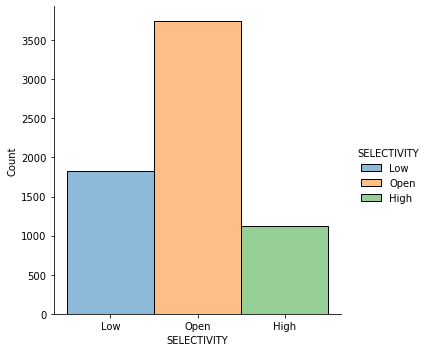

In [9]:
sns.displot(data=rate_df, x = 'SELECTIVITY', hue = 'SELECTIVITY')

The majority of schools are open enrollment with the second most popular selection rate being low and the least popular rate being high. 

## Completion Rate and Race

<AxesSubplot:>

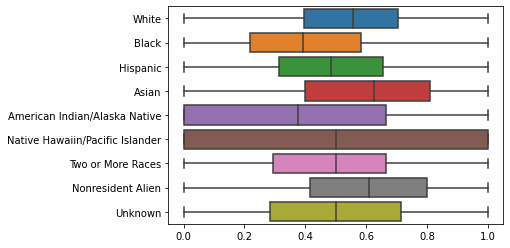

In [10]:
#Creation of dataframe for plotting
race_grad_rate = df[['C150_4_WHITE','C150_4_BLACK','C150_4_HISP','C150_4_ASIAN','C150_4_AIAN','C150_4_NHPI','C150_4_2MOR','C150_4_NRA','C150_4_UNKN','C150_L4_WHITE','C150_L4_BLACK','C150_L4_HISP','C150_L4_ASIAN','C150_L4_AIAN','C150_L4_NHPI','C150_L4_2MOR','C150_L4_NRA','C150_L4_UNKN']]
race_grad_rate.C150_4_WHITE.fillna(race_grad_rate['C150_L4_WHITE'])
del race_grad_rate['C150_L4_WHITE']
race_grad_rate.C150_4_BLACK.fillna(race_grad_rate['C150_L4_BLACK'])
del race_grad_rate['C150_L4_BLACK']
race_grad_rate.C150_4_ASIAN.fillna(race_grad_rate['C150_L4_ASIAN'])
del race_grad_rate['C150_L4_ASIAN']
race_grad_rate.C150_4_AIAN.fillna(race_grad_rate['C150_L4_AIAN'])
del race_grad_rate['C150_L4_AIAN']
race_grad_rate.C150_4_HISP.fillna(race_grad_rate['C150_L4_HISP'])
del race_grad_rate['C150_L4_HISP']
race_grad_rate.C150_4_NHPI.fillna(race_grad_rate['C150_L4_NHPI'])
del race_grad_rate['C150_L4_NHPI']
race_grad_rate.C150_4_2MOR.fillna(race_grad_rate['C150_L4_2MOR'])
del race_grad_rate['C150_L4_2MOR']
race_grad_rate.C150_4_UNKN.fillna(race_grad_rate['C150_L4_UNKN'])
del race_grad_rate['C150_L4_UNKN']
race_grad_rate.C150_4_NRA.fillna(race_grad_rate['C150_L4_NRA'])
del race_grad_rate['C150_L4_NRA']
race_grad_rate = race_grad_rate.rename(columns={'C150_4_WHITE':'White','C150_4_BLACK':'Black','C150_4_HISP':'Hispanic','C150_4_ASIAN':'Asian','C150_4_AIAN':'American Indian/Alaska Native','C150_4_NHPI':'Native Hawaiin/Pacific Islander','C150_4_2MOR':'Two or More Races','C150_4_NRA':'Nonresident Alien','C150_4_UNKN':'Unknown'})

sns.boxplot(data=race_grad_rate, orient = 'h')

Black students and American Indian / Alaska Natives are the least likely to complete their degree within 150% of normal time while Asian students are the most likely. 

## Completion Rate and School Selectivity

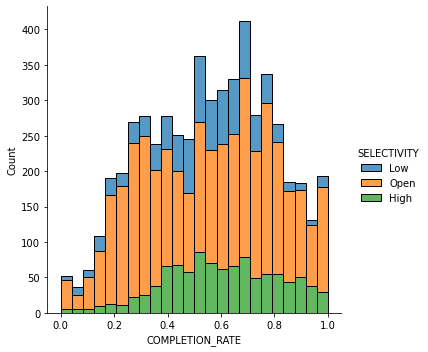

In [11]:
sns.displot(data = rate_df, x = 'COMPLETION_RATE', hue = 'SELECTIVITY', multiple = 'stack')

Despite admitting the most students, open enrollment schools do not have the highest completion rates. Low selectivity schools produce the most student program completions per capita, and the high selectivity schools finish about where one would expect considering they bring in the least amount of students. 

## Completion Rate and School Type

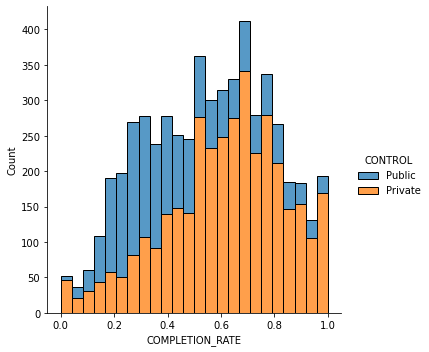

In [12]:
sns.displot(data = rate_df, x = 'COMPLETION_RATE', hue = 'CONTROL', multiple = 'stack')

There seems to be little difference in completion rate when comparing public to private schools. There are more public schools, so it is expected that they would have a higher total number of program completions. 

## Completion Rate and Cost

I'm looking at the completion rate with cost because the expenses that come with postsecondary eductation are such a hot topic these days. Could it be the case that paying more for school causes one to value it more and have a stronger drive to finish? 

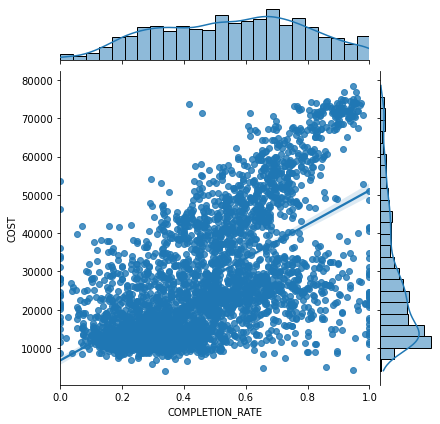

In [13]:
sns.jointplot(data = rate_df, x = 'COMPLETION_RATE', y = 'COST', kind = 'reg')

Interesting...it seems there is a positive correlation between a school's cost of attendance, and the school's completion rates. 

## Conclusion on Completion Rate
When looking at completion rates, it seems that the schools doing the best are ones that have low selectivity and cost in the mid to high range. Public/private status seems to have no effect on completion rates, but the race of an individual student does seem to play a factor. Although, much more analyisis can be done with this dataset, and this merely scrapes the surface of the real reasons behind these trends. 